In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
import healpy as hp

In [4]:
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import ICRS

In [5]:
from __future__ import unicode_literals

figsize(10,8)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 12
rcParams['legend.borderaxespad'] = 2

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [6]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [7]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [12]:
def calculate_sflux_gal(bank='A', session='5', doplot=True, pixbeam=1., smth=0, removeplane=True):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/tod'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    c = coordinates.SkyCoord(frame='fk5', ra=ras*u.degree, dec=decs*u.degree)
    decs = c.galactic.b.deg
    ras = c.galactic.l.deg
    rc = 107.2
    dc = 5.2
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units
    # beam and pixbeam are in arcminutes
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    # ras and decs are in degrees 
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= 1.
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    annulus = (radius >= 80./60.) & (radius <= 2.)
    #annulus = radius >= 1.
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0
    
    #region = radius <= 3.5 
    #regiondata = np.zeros_like(calibrated)
    #regiondata[region] = 10.
    #regionmap, regionhits, rabins, decbins = naive_map(regiondata, ras, decs, nrapix, ndecpix)
    #regionregion = regionmap > 0

    rabinsc = (rabins[1:] + rabins[:-1]) / 2.
    decbinsc = (decbins[1:] + decbins[:-1]) / 2.
    if removeplane:
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        masks = ~np.isnan(Z) * ~innerregion.flatten() #* regionregion.flatten()
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
        
    signal -= np.nanmedian(signal[outerregion])
    if smth is None:
        smth = beam
    if smth > 0:
        sigma = smth / pixbeam / (2. * np.sqrt(2. * np.log(2)))
        signal = gaussian_filter(signal, sigma)
        shits = gaussian_filter(hits, sigma)
        mask = shits < 1
    signal[mask] = np.nan
    
    if doplot:
        figure()
        pc = pcolormesh(rabinsc, decbinsc, signal * 1000.)
        #pc = pcolormesh(rabinsc, decbinsc, outerregion)
        clim(-12, 12)
        cb = colorbar()
        xlabel('$\mathrm{Lon}\ (deg)$')
        ylabel('$\mathrm{Lat}\ (deg)$')
        cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
        grid(alpha=0.7)
        title('$6.2~GHz$')
        #savefig('s4map_bank'+bank+'session'+session)
    
    print np.nansum(signal[innerregion]), np.nanstd(signal[outerregion]) * np.sqrt(innerregion.sum())
    return signal, rabins, decbins

30.9373740253 0.717652958175


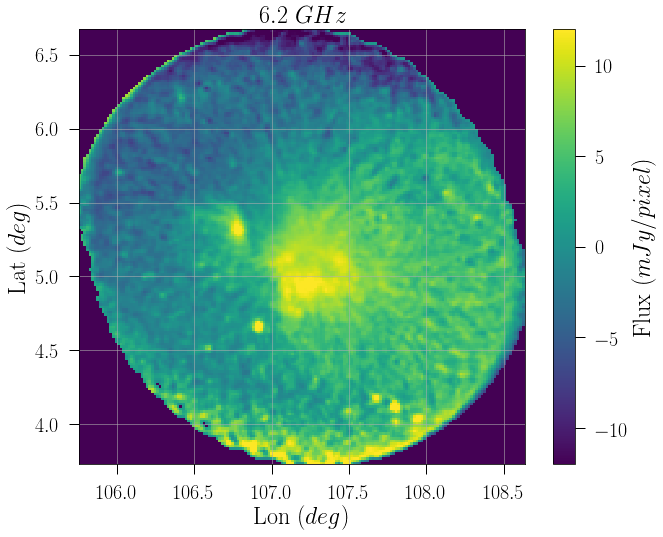

In [13]:
signal, rabins, decbins = calculate_sflux_gal('C', smth=None)

In [16]:
np.nanmean(signal)

0.0014448945655553612

In [18]:
np.nanstd(signal) * 1000

4.5775344339105493

31.5212865486 0.573716159175


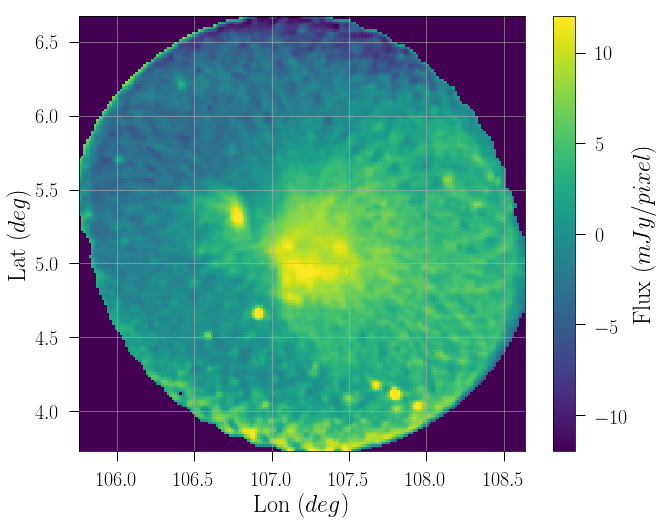

In [32]:
signal, rabins, decbins = calculate_sflux_gal('B', smth=None)

30.9373740253 0.717652958175


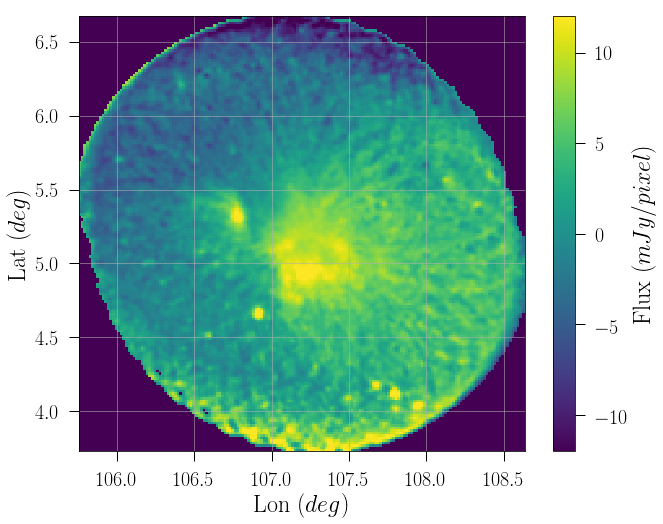

In [33]:
signal, rabins, decbins = calculate_sflux_gal('C', smth=None)

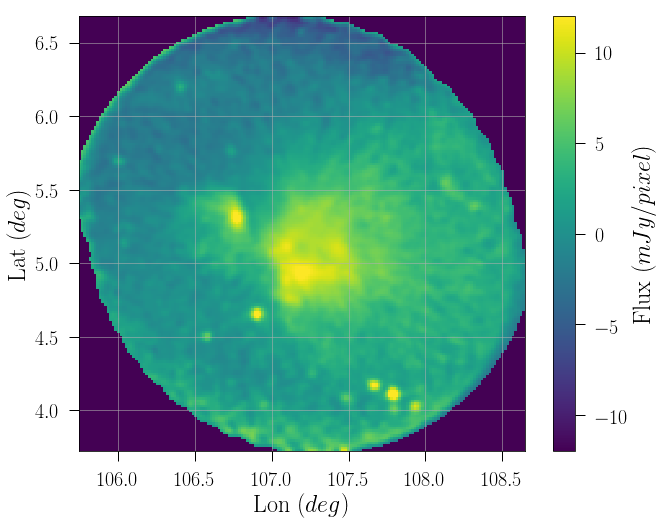

In [20]:
figure()
pc = pcolormesh(rabins, decbins, signal * 1000.)
clim(-12, 12)
cb = colorbar()
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid(alpha=0.7)
#savefig('s4map_bank'+bank+'session'+session)

In [21]:
signal, rabins, decbins = calculate_sflux_gal('B', smth=None, doplot=False)

31.5212865486 0.573716159175


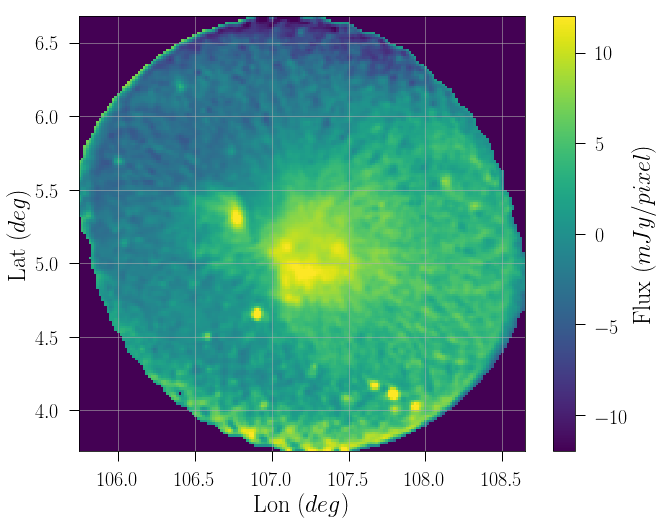

In [22]:
figure()
pc = pcolormesh(rabins, decbins, signal * 1000.)
clim(-12, 12)
cb = colorbar()
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid(alpha=0.7)
#savefig('s4map_bank'+bank+'session'+session)

In [23]:
signal, rabins, decbins = calculate_sflux_gal('C', smth=None, doplot=False)

30.9373740253 0.717652958175


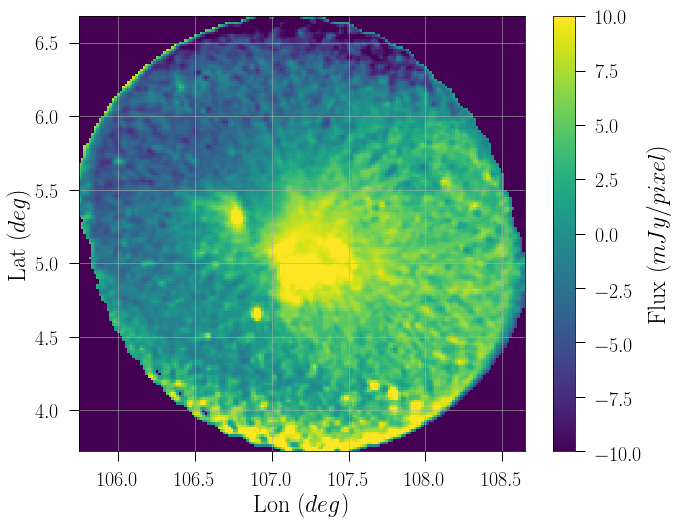

In [25]:
figure()
pc = pcolormesh(rabins, decbins, signal * 1000.)
clim(-12, 12)
cb = colorbar()
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid(alpha=0.7)
#savefig('s4map_bank'+bank+'session'+session)

In [106]:
rabins.shape

(173,)

In [104]:
rabins.min(), rabins.max()

(105.75372225704224, 108.63984677365949)

In [107]:
decbins.shape

(176,)

In [105]:
decbins.min(), decbins.max()

(3.730808938819024, 6.6709289386306425)

In [90]:
flux = []
for bank in banks:
    calculate_sflux_gal(bank, '2', smth=60., removeplane=True, doplot=False)

34.1519730483 0.125795984167
42.3762234972 0.183737249971
46.1952472309 0.216159756206
8.03831908909 0.339226976982


In [93]:
flux = []
for bank in banks:
    calculate_sflux_gal(bank, '2', smth=60., removeplane=True, doplot=False)

36.1522134611 0.130479561673
45.6166887597 0.187936745877
49.5306468301 0.22189159409
10.3288766747 0.569874435447


In [95]:
flux = []
for bank in banks:
    calculate_sflux_gal(bank, '2', smth=60., removeplane=False, doplot=False)

43.9264429288 0.241254039425
57.807176237 0.361319227435
64.2958544943 0.43613701183
30.6996861899 0.927438818633


In [97]:
flux = []
for bank in banks:
    calculate_sflux_gal(bank, '2', smth=None, removeplane=False, doplot=False)

51.8083540416 0.450398792277
67.9128628371 0.735987676015
76.1936322436 0.927399289138
88.1644839344 2.38865838694


In [94]:
flux = []
for bank in banks:
    calculate_sflux_gal(bank, '5', smth=60., removeplane=True, doplot=False)

24.9938740036 0.119501332597
24.9551930934 0.170289047328
24.6009179754 0.202676793831
0.187908260509 0.51478667639


In [96]:
flux = []
for bank in banks:
    calculate_sflux_gal(bank, '5', smth=60., removeplane=False, doplot=False)

19.5281920348 0.383253088532
18.8818538031 0.585380225542
19.1756631803 0.711860150408
-1.90950484545 1.48040856986


24.2747109028 0.570216005665
23.6016528974 0.884745851682
24.2256506122 1.08501996023
23.9994730884 2.39912712003


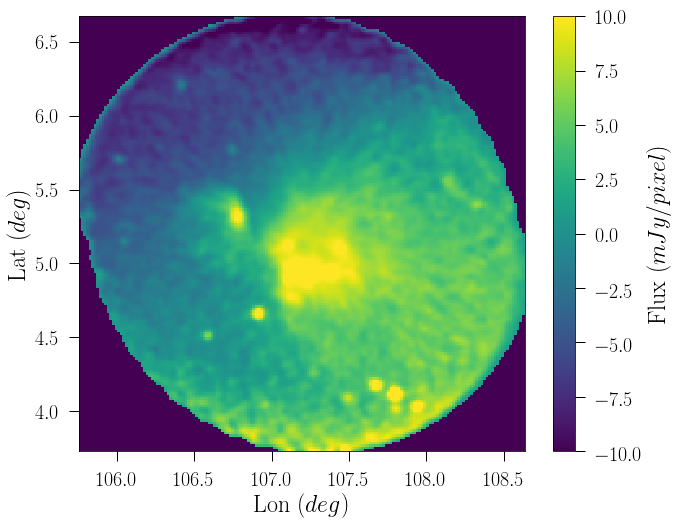

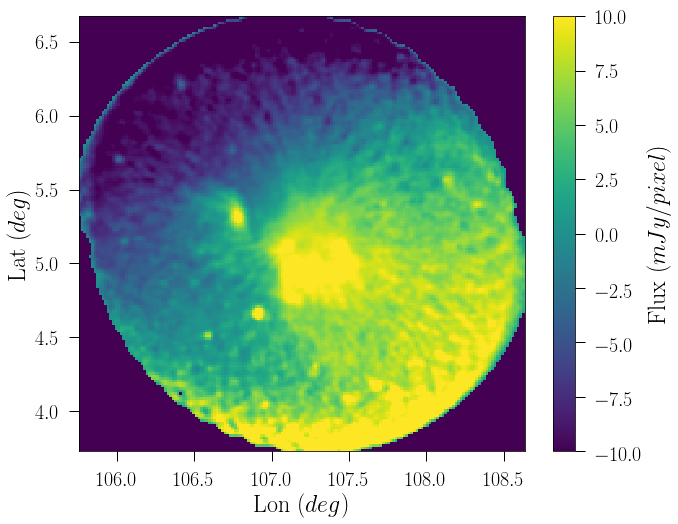

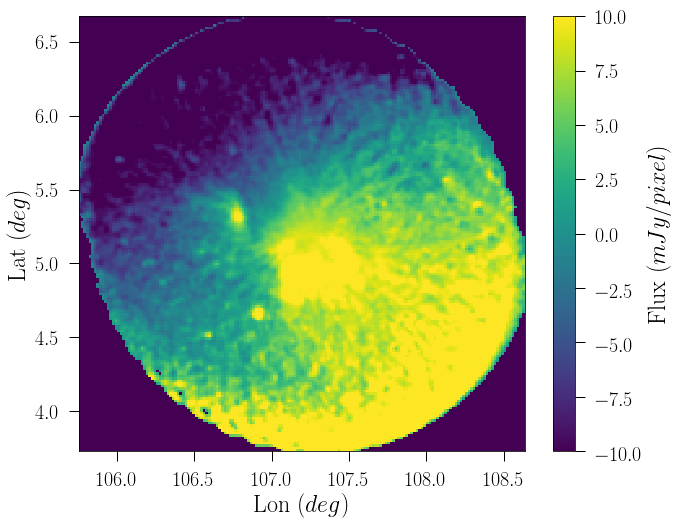

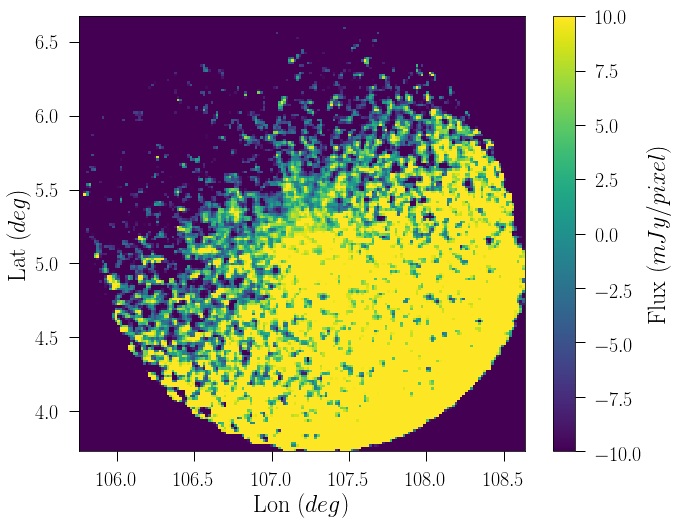

In [99]:
flux = []
for bank in banks:
    calculate_sflux_gal(bank, '5', smth=None, removeplane=False, doplot=True)

29.7358705189 0.280667851361
29.6680936833 0.426411020569
29.6425313977 0.525169645939
26.0799049242 1.39743375694


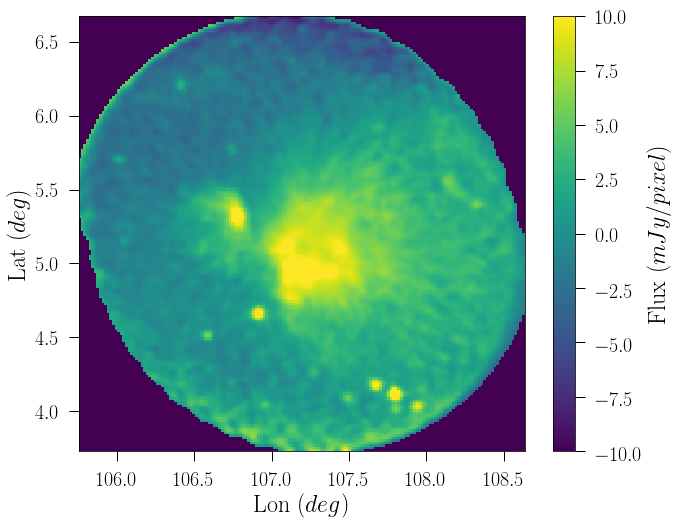

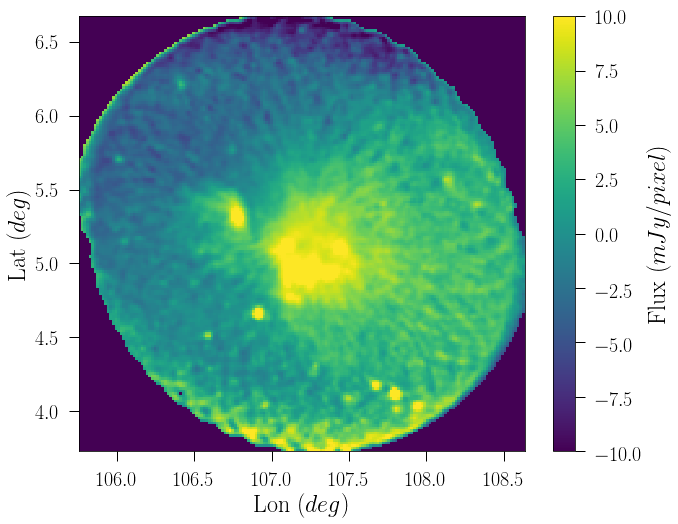

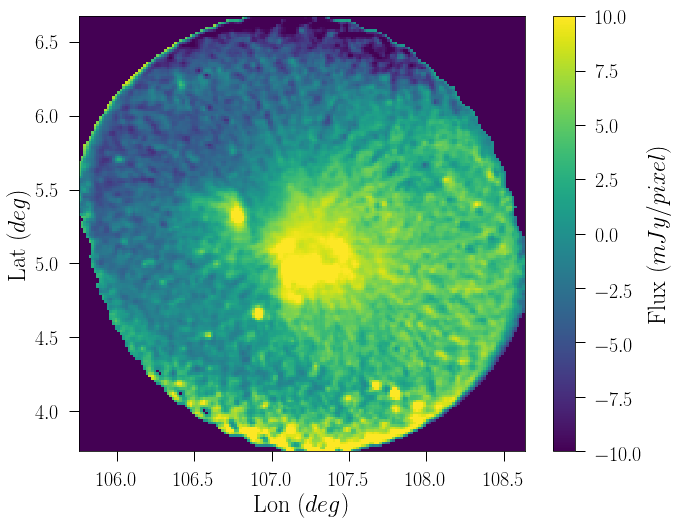

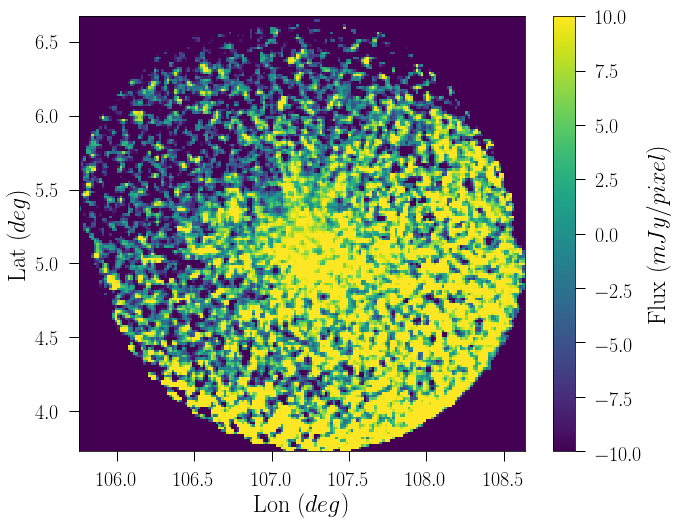

In [100]:
flux = []
for bank in banks:
    calculate_sflux_gal(bank, '5', smth=None, removeplane=True, doplot=True)

In [80]:
radius.max()

3.390883483302785

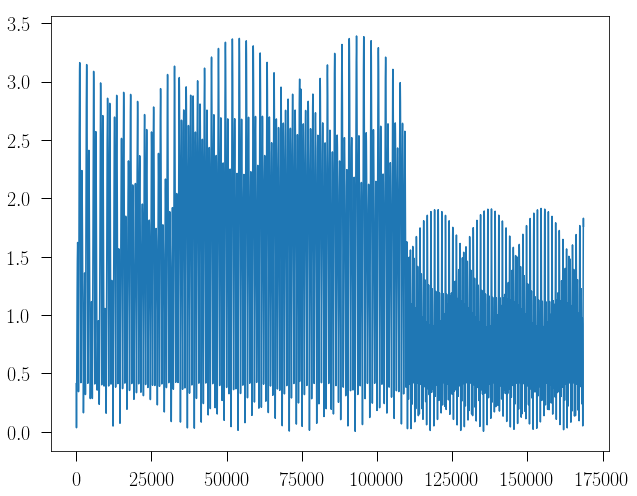

In [101]:
plot(radius)

32.8297885174 0.715375876174


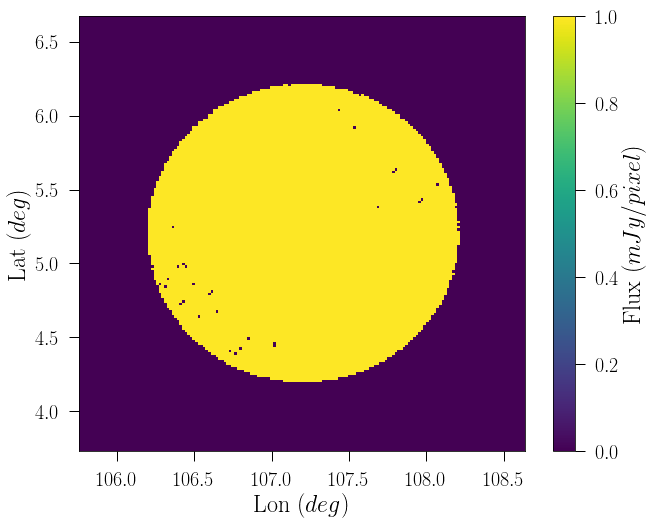

In [69]:
calculate_sflux_gal('A', '5', smth=None, removeplane=False)

34.127129108 0.350849015636


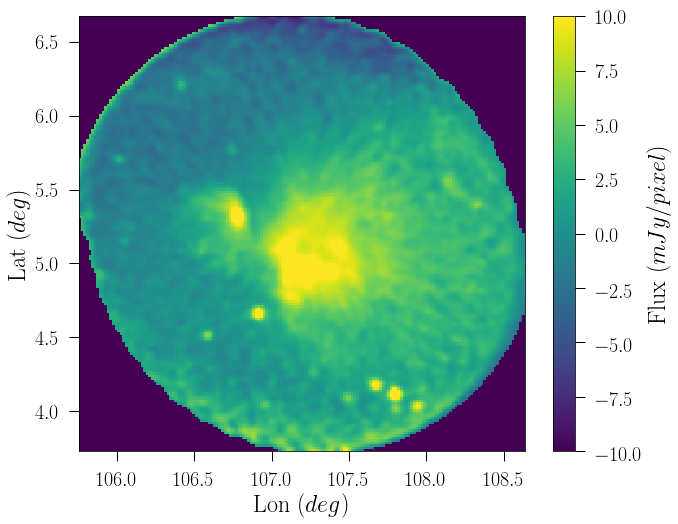

In [63]:
calculate_sflux_gal('A', '5', smth=None, removeplane=True)

37.1004231969 1.14672062835


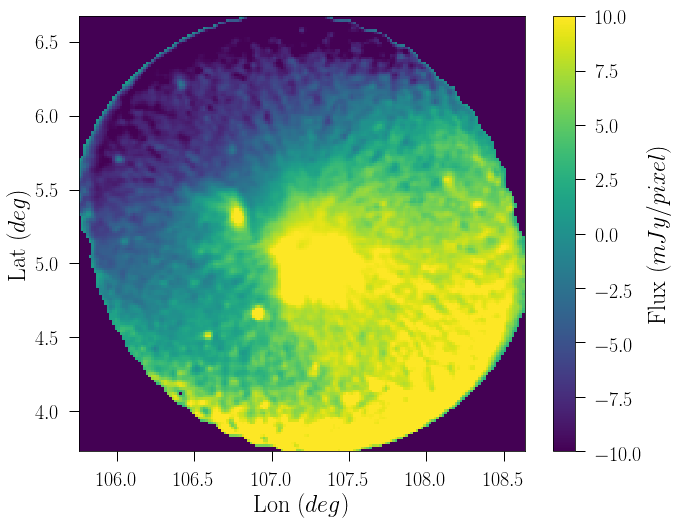

In [64]:
calculate_sflux_gal('B', '5', smth=None, removeplane=False)

31.5212865486 0.573716159175


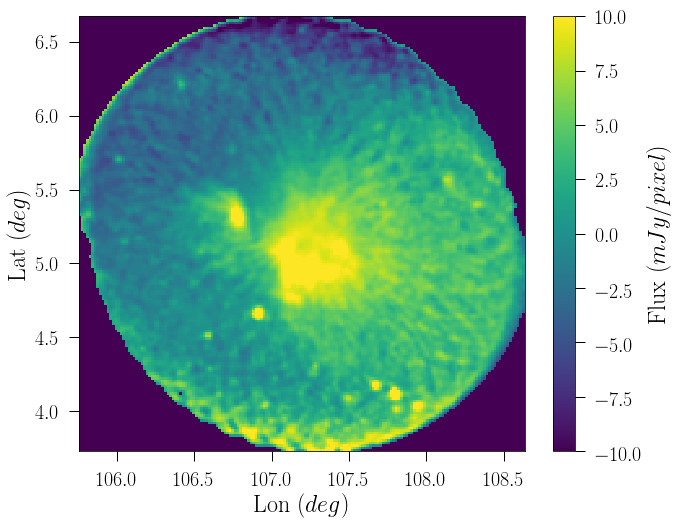

In [65]:
calculate_sflux_gal('B', '5', smth=None, removeplane=True)